In [3]:
#导入numpy包后续进行数据处理
import numpy as np # linear algebra

#导入matplotlib包后续进行画图
import matplotlib.pyplot as plt

#内嵌画图，使图像显示在该页面内
%matplotlib inline

#导入train_test_split包划分数据集为训练集，验证集
from sklearn.model_selection import train_test_split

#导入confusion_matrix(混淆矩阵)，查看真实值被正确或者错误预测的个数
from sklearn.metrics import confusion_matrix

In [4]:
#one-hot编码，采用独热码编码，直观来说就是有多少个状态就有多少比特，而且只有一个比特为1，其他全为0的一种码制，构造稀疏矩阵，解决分类值表示的问题对模型产生的负面影响
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

#导入顺序Sequential模型，后续可直接在Sequential上构建神经网络
from keras.models import Sequential

#Dense：全连接层；Dropout正则化数据；Flatten压平数据连接全连接层，Conv2D卷积层卷积计算，BatchNormalization数据规范化输出数据的均值接近0，其标准差接近1
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

#导入优化器Adam，基于一阶梯度的随机目标函数优化算法
from keras.optimizers import Adam

#导入ImageDataGenerator图像增广技术来扩充我们的数据集
from keras.preprocessing.image import ImageDataGenerator

#导入LearningRateScheduler动态修改学习率的回调函数
from keras.callbacks import LearningRateScheduler

C:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '

In [5]:
#根据自己所下载数据设置对应的路径
train_file = "train.csv"
test_file = "test.csv"
output_file = "submission.csv"

In [6]:
#numpy导入数据，np.loadtxt
#loadtxt(fname, dtype=<class 'float'>, comments='#', delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
#fname要读取的文件、文件名、或生成器。
#dtype数据类型，默认float。
#comments注释。
#delimiter分隔符，默认是空格。
#skiprows跳过前几行读取，默认是0，必须是int整型。
#usecols：要读取哪些列，0是第一列。例如，usecols = （1,4,5）将提取第2，第5和第6列。默认读取所有列。
#unpack如果为True，将分列读取
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')



#划分数据集为训练集和验证集
#train_test_split(train_data,train_target,test_size=0.3, random_state=0)
#train_data：被划分的样本特征集
#train_target：被划分的样本标签
#test_size：如果是浮点数，在0-1之间，表示测试集样本占比；如果是整数的话就是样本的数量
#random_state：是随机数的种子,使每次产生的随机数一样
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

Text(0.5,1,'28x28 data')

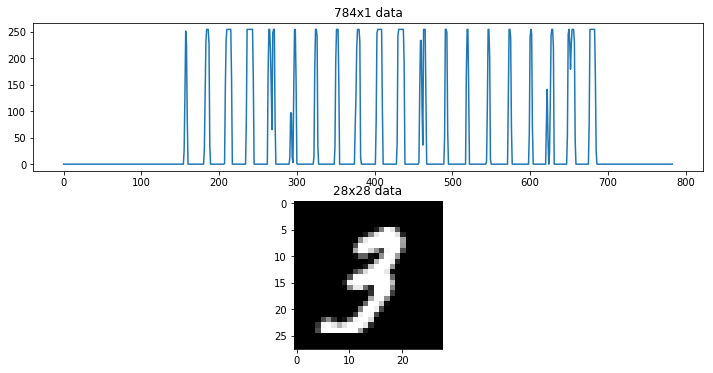

In [7]:
#subplots:子图显示，fig, ax = subplots(nrows, ncols，figsize）
#fig代表整个图像，ax代表坐标轴和画的图
#nrows，ncols：子图的行列数
#figsize：显示图形大小
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
#设置标题
ax[0].set_title('784x1 data')
#图形显示x_train数据
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
#设置标题
ax[1].set_title('28x28 data')

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1) （重塑三维图像）
#784个输入，转成28 * 28 + 颜色通道
#-1表示自动计算行数并填充
#注意keras的颜色通道表示在最后一个参数(跟其他框架不同)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [9]:
#正则化数据，使矩阵内的数据规约到0到1之间，减少计算量，提升模型训练效率
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [10]:
#to_categorical(data,num_classes)：one-hot编码(独热码编码)，在对应的标签置1，其余的全部为0,num_classes表示多少个标签
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#例如：2  −>−>  [0,0,1,0,0,0,0,0,0,0]
#example:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [11]:
#定义顺序模型Sequential，Sequential是多个网络层的线性堆叠
#通常是由以下几层构成：数据输入层(Input)，卷积层(Convolutional)，池化层(Pooling)，全连接层(Dense)，数据输出层(Output)
model = Sequential()

#filters：整数，输出空间的维度（即卷积中滤波器的输出数量），滤波器做卷积计算用的，卷积计算的过程也正是图形匹配的过程。
#kernel_size：一个整数，或者单个整数表示的元组或列表，指明1D卷积窗口的长度（即卷积滤波器窗口大小）。
#activation：激活函数，relu激活函数是指让负数输出为0，正数原样输出。
#传递一个input_shape的关键字参数给第一层，input_shape是一个tuple类型的数据，其中也可以填入None，如果填入None则表示此位置可能是任何正整数。数据的batch大小不应包含在其中
#这里input_shape = (28, 28, 1)指28*28矩阵输入，1为颜色通道，灰色图则为1，rgb图则为3。
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))


#BatchNormalization：规范化，该层在每个批次上将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1
#作用：（1）加速收敛（2）控制过拟合，可以少用或不用Dropout和正则（3）降低网络对初始化权重不敏感（4）允许使用较大的学习率
model.add(BatchNormalization())

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())


#MaxPooling图层只查看四个相邻像素并选取最大值。这将图像的大小减小了一半
#strides设置查看窗口大小，即在相邻的几个像素中做处理
model.add(MaxPool2D(strides=(2,2)))


#Dropout：正则化层，随机地将每个训练样本的一部分权重替换为零，简单一点说在前向传播的时候，让某个神经元的激活值以一定的概率p停止。下面补充Dropout工作原理
#作用：1.降低模型复杂度，增强模型的泛化能力，防止过拟合。2.降低了运算量。
model.add(Dropout(0.25))


model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

#Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到(Convolution)全连接层(Dense)的过渡。
#也就是说，Convolution卷积层之后是无法直接连接Dense全连接层的，需要把Convolution层的数据压平（Flatten）。
model.add(Flatten())
#Dense(512)表示output的shape为(*,32)
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

#Dense(10)表示output的shape为(*,10)，也就0-9的10个数字标签。
model.add(Dense(10, activation='softmax'))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
#图像增广技术扩充数据集
#zoom_range参数可以调整图片在长或宽的方向进行放大，这个参数可以是一个数或者是一个list。当给出一个数时，图片同时在长宽两个方向进行同等程度的放缩操作；当给出一个list时，则代表[width_zoom_range, height_zoom_range]，即分别对长宽进行不同程度的放缩。而参数大于0小于1时，执行的是放大操作，当参数大于1时，执行的是缩小操作
#width_shift_range是水平位置平移 。height_shift_range竖直位置平移。
#其参数可以是[0, 1]的浮点数，也可以大于1，但最好不要大于1，超出原图范围的区域大多效果不好，其最大平移距离为图片长或宽的尺寸乘以参数，同样平移距离并不固定为最大平移距离，平移距离在 [0, 最大平移距离] 区间内。
#rotation range的作用是用户指定旋转角度范围，其参数只需指定一个整数即可，可在 [0, 指定角度] 范围内进行随机角度旋转。
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)


In [13]:
#API:model.compile(optimizer = '...', loss = '...', metrics = )
#优化器optimizer：该参数可指定为已预定义的优化器名，如rmsprop、adagrad，或一个Optimizer类的对象
#损失函数loss：该参数为模型试图最小化的目标函数，它可为预定义的损失函数名，如categorical_crossentropy、mse，也可以为一个损失函数。
#指标列表metrics：对分类问题，我们一般将该列表设置为metrics=[‘accuracy’]。指标可以是一个预定义指标的名字,也可以是一个用户定制的函数.指标函数应该返回单个张量,或一个完成metric_name - > metric_value映射的字典.

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
#LearningRateScheduler动态修改学习率的回调函数，用于动态设置学习率，这里调用lambda函数
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)


In [16]:
#fit_generator模型的训练
#datagen.flow加载训练数据
# batch_size=None, #每经过多少个sample更新一次权重，defult 32
# epochs=1, #训练的轮数epochs
# verbose=1, #0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
# validation_data=None, #验证集
# steps_per_epoch=None, #将一个epoch分为多少个steps，也就是划分一个batch_size多大，比如steps_per_epoch=10，则就是将训练集分为10份，不能和batch_size共同使用
# validation_steps=None, #当steps_per_epoch被启用的时候才有用，验证集的batch_size
# callbacks=None,#list，list中的元素为keras.callbacks.Callback对象，在训练过程中会调用list中的回调函数

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])
#训练集的正确率和误差：acc，loss
#验证集正确率和误差：val_acc，val_loss


Epoch 1/50
 - 209s - loss: 0.2878 - acc: 0.9142 - val_loss: 0.0943 - val_acc: 0.9700
Epoch 2/50
 - 201s - loss: 0.1804 - acc: 0.9500 - val_loss: 0.0478 - val_acc: 0.9875
Epoch 3/50
 - 199s - loss: 0.1525 - acc: 0.9571 - val_loss: 0.0406 - val_acc: 0.9900
Epoch 4/50
 - 198s - loss: 0.1240 - acc: 0.9667 - val_loss: 0.0200 - val_acc: 0.9900
Epoch 5/50
 - 197s - loss: 0.1159 - acc: 0.9676 - val_loss: 0.0500 - val_acc: 0.9875
Epoch 6/50
 - 198s - loss: 0.1022 - acc: 0.9720 - val_loss: 0.0648 - val_acc: 0.9800
Epoch 7/50
 - 199s - loss: 0.0888 - acc: 0.9759 - val_loss: 0.0373 - val_acc: 0.9875
Epoch 8/50
 - 213s - loss: 0.0917 - acc: 0.9751 - val_loss: 0.0318 - val_acc: 0.9875
Epoch 9/50
 - 179s - loss: 0.0759 - acc: 0.9797 - val_loss: 0.0394 - val_acc: 0.9900
Epoch 10/50
 - 171s - loss: 0.0717 - acc: 0.9800 - val_loss: 0.0227 - val_acc: 0.9875
Epoch 11/50
 - 171s - loss: 0.0654 - acc: 0.9816 - val_loss: 0.0292 - val_acc: 0.9925
Epoch 12/50
 - 171s - loss: 0.0660 - acc: 0.9814 - val_loss: 0.

In [17]:
#evaluate：模型评估，返回损失函数和指定的精确指标
#evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None)
#x_val：数据
#y_val：标签
#batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
#sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
#修改输出格式
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


Final loss: 0.0166, final accuracy: 0.9952


In [18]:
#模型的预测：predict(x, batch_size=None, verbose=0, steps=None, callbacks=None)
#x：输入数据，作为Numpy数组（如果模型有多个输入，则为Numpy数组列表）。
#batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
#step：在宣布预测轮次结束之前的步骤总数（样本批次）
# callbacks=None,#list，list中的元素为keras.callbacks.Callback对象，在训练过程中会调用list中的回调函数
y_hat = model.predict(x_val)

#numpy.argmax(a, axis=None, out=None)，返回沿轴axis最大值的索引。
#a：数据
#axis = 1表示沿横轴，axis = 0表示沿纵轴
#返回取得最大值的索引
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)

#confusion_matrix(混淆矩阵)：查看真实值被正确或者错误预测的个数，对角线表示0到9被正确预测的个数
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[411   0   0   0   1   0   0   0   0   0]
 [  0 455   0   0   0   0   1   1   0   0]
 [  0   0 408   0   0   0   0   1   0   0]
 [  0   0   0 441   0   0   0   0   1   0]
 [  0   0   0   0 400   0   0   0   0   0]
 [  0   0   0   0   0 391   0   0   2   0]
 [  1   0   0   0   2   0 411   0   0   0]
 [  1   0   1   0   0   0   0 447   0   0]
 [  0   0   0   0   0   0   0   0 374   1]
 [  0   0   0   0   3   0   0   1   3 442]]


In [19]:
#参考上述数据导入
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.


In [20]:
#参考上述数据预测
y_hat = model.predict(x_test, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

#将预测值写入文件保存
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))
